In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

## Reading

In [3]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 150

In [4]:
row_start = 14

In [5]:
metadata = dict()
filename = "T0014ALL.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '1e-05',
 'Sample Interval': '1e-09',
 'Filter Frequency': '2e+08',
 'Record Length': '100000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '0.5',
 'Label': ''}

In [6]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH2
0,0.00095,0.00,0.01
1,0.00095,0.02,0.03
2,0.00095,0.00,0.01
3,0.00095,0.00,0.01
4,0.00095,0.00,0.01
...,...,...,...
99995,0.00105,0.00,0.01
99996,0.00105,-0.02,0.01
99997,0.00105,0.00,0.01
99998,0.00105,0.00,0.01


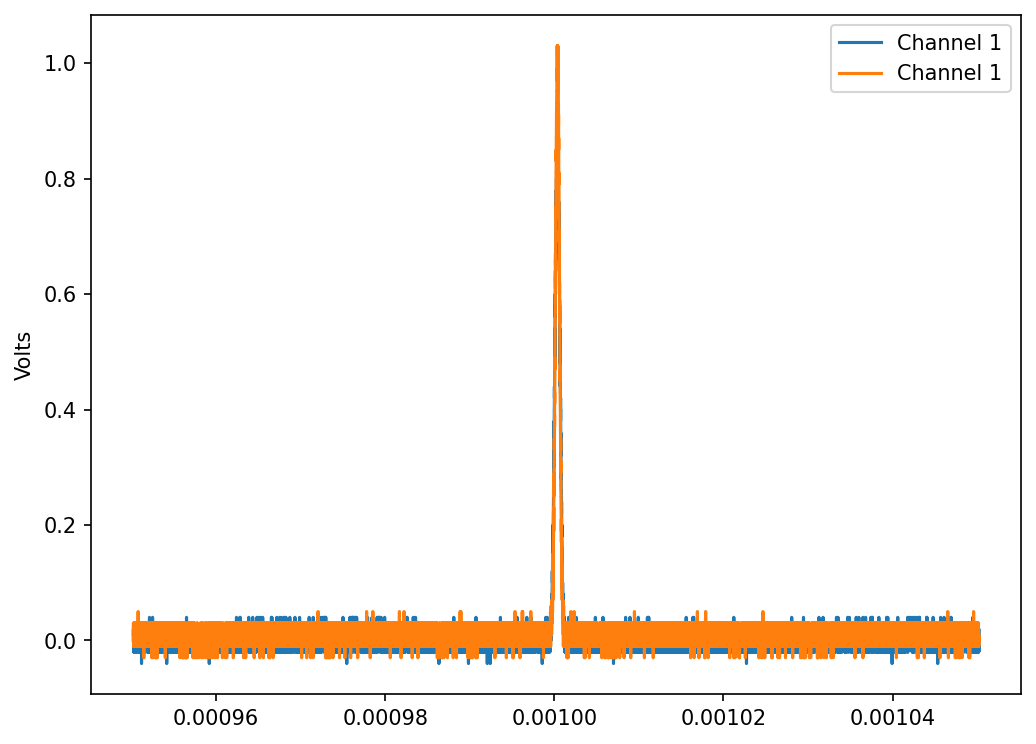

In [10]:
t_raw = data["TIME"].to_numpy()
ch1_raw = data["CH1"].to_numpy()
ch2_raw = data["CH2"].to_numpy()
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 1"
)

plt.ylabel("Volts")
plt.legend()

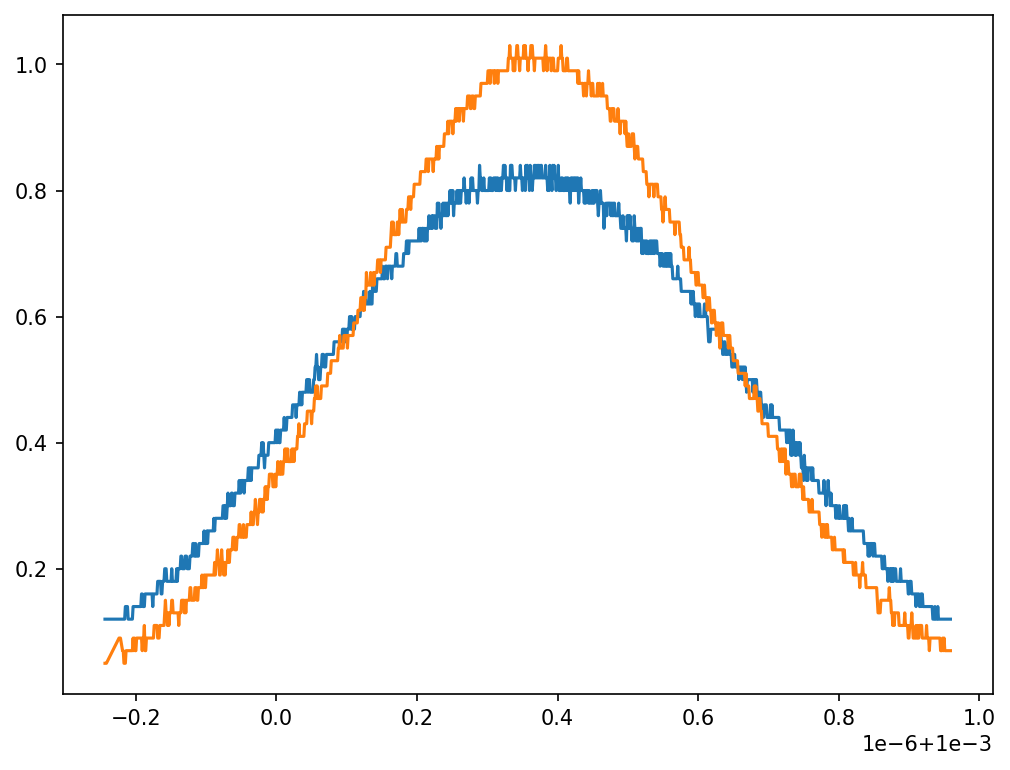

In [11]:
t = t_raw[ch1_raw>0.1]
ch1 = ch1_raw[ch1_raw>0.1]
ch2 = ch2_raw[ch1_raw>0.1]
plt.plot(t, ch1)
plt.plot(t, ch2)
plt.show()

array([[inf, inf],
       [inf, inf]])

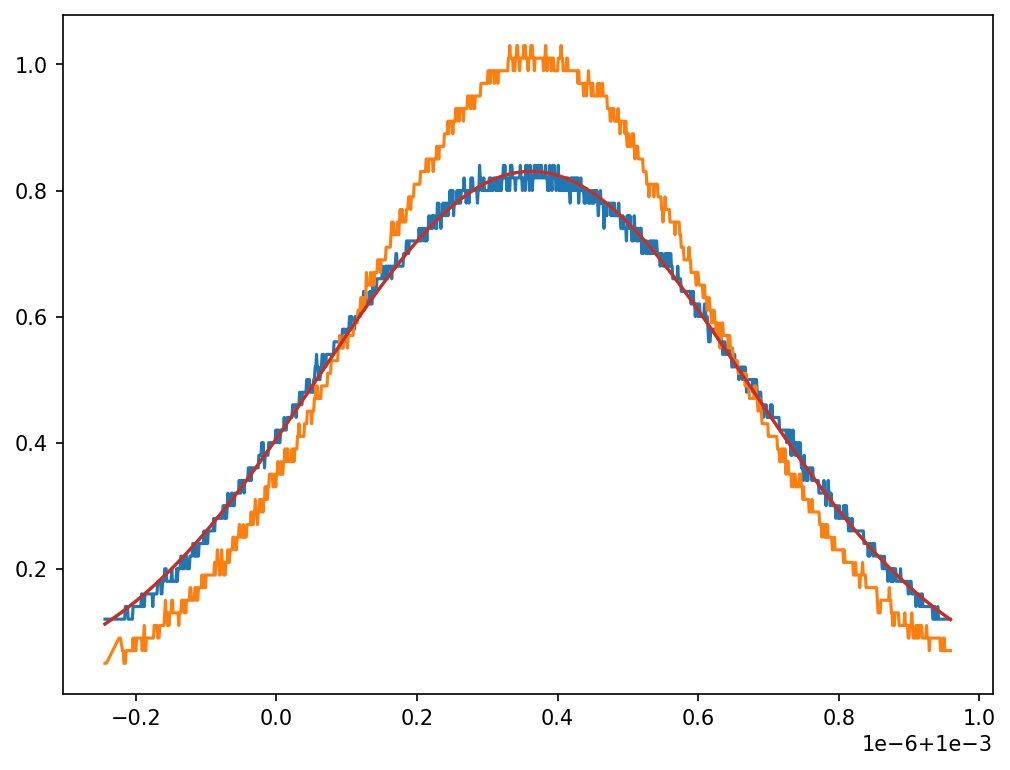

In [79]:
gaussian = lambda t, A, mu, sigma: A * np.exp(-((t - mu)/(2*sigma))**2)
[[A1, mu1, sigma1], cov1] = sp.optimize.curve_fit(gaussian, t, ch1, p0=[1, 0, 1e-3])

double_gaussian = lambda t, A, d: A * (
    gaussian(t, A1, mu1 + d, sigma1)
    + gaussian(t, A1, mu1 - d, sigma1)
)/2

# [[A2, d2], cov2] = sp.optimize.curve_fit(double_gaussian, t, ch2, p0=[1, 5e-9])


plt.plot(t, ch1)
plt.plot(t, ch2)
plt.plot(t, gaussian(t, A1, mu1, sigma1))
plt.plot(t, double_gaussian(t, 1, 1e-10))

cov2

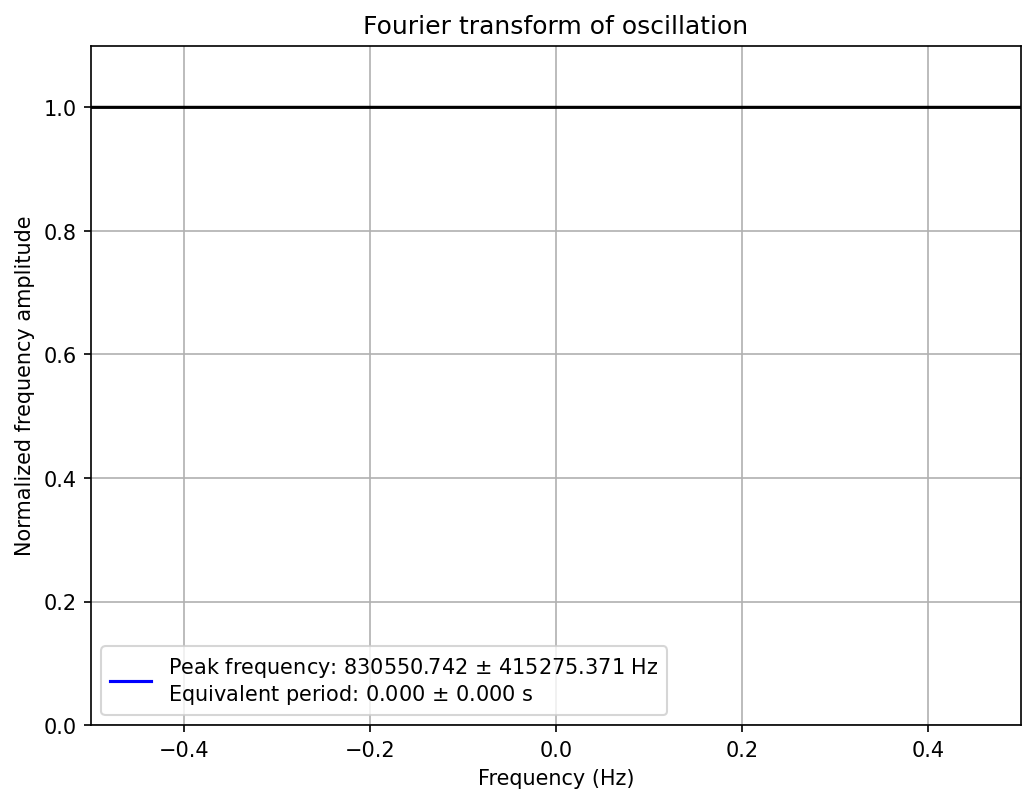

In [22]:
from scipy.fft import fft, fftfreq, fftshift

spectrum = np.abs(fftshift(fft(ch1)))
spectrum /= np.max(spectrum)
sampling_rate = 1 / np.average(np.diff(t))
freq = fftshift(fftfreq(t.size, 1/sampling_rate))
bin_width = np.average(np.diff(freq))

maxfreq = freq[freq > 1][np.argmax(spectrum[freq > 1])]
leftfreq = maxfreq - bin_width/2
rightfreq = maxfreq + bin_width/2
plt.axvline(maxfreq, color="blue", 
            label=f"""Peak frequency: {maxfreq:.3f} $\pm$ {bin_width/2:.3f} Hz
Equivalent period: {1/maxfreq:.3f} $\pm$ {1/leftfreq - 1/rightfreq:.3f} s""")
plt.axvspan(
    leftfreq, 
    rightfreq, 
    color="lightblue")

plt.title("Fourier transform of oscillation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized frequency amplitude")
plt.xlim(-0.5, 0.5)
plt.ylim(0, 1.1)
plt.plot(freq, spectrum, color="black")
plt.grid()
plt.legend()
plt.show()